In [1]:
#import libs
import pandas as pd
import numpy as np
import random

import matplotlib
from matplotlib.dates import DateFormatter
import matplotlib.pyplot as plt

from datetime import datetime

import os, warnings
warnings.filterwarnings('ignore')

In [2]:
## preparing time series
# Reading nc file with xarray
import xarray as xr
filename = r'.\data\land-monthly-tem-15-18.nc'
DS = xr.open_dataset(filename)
DS

<xarray.Dataset>
Dimensions:    (latitude: 381, longitude: 261, time: 48)
Coordinates:
  * longitude  (longitude) float32 42.0 42.1 42.2 42.3 ... 67.7 67.8 67.9 68.0
  * latitude   (latitude) float32 48.0 47.9 47.8 47.7 ... 10.3 10.2 10.1 10.0
  * time       (time) datetime64[ns] 2015-01-01 2015-02-01 ... 2018-12-01
Data variables:
    t2m        (time, latitude, longitude) float32 ...
    tp         (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2021-06-09 06:43:56 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...

In [3]:
## Select specific region (bounding box method)
def get_era5(dataset, bounding_box, alpha=1, resulotion=0.25):
    #y
    llat = bounding_box[0]
    ulat = bounding_box[1]
    #x
    llon = bounding_box[2]
    rlon = bounding_box[3]
    
    area_ds = dataset.sel(longitude=slice(llon-alpha*resulotion, rlon+alpha*resulotion), 
                     latitude=slice(ulat+alpha*resulotion, llat-alpha*resulotion))

    # take average all grids
    # convert kelvin to celsuis (K - 273.15 = c)
    era_temp = area_ds.t2m.mean(dim=['latitude', 'longitude'])[:]-273.15
    era_temp = era_temp.to_dataframe()
    
    return era_temp


In [4]:
# reading synoptic data
def get_ground(sfile):
    
    xl = pd.ExcelFile(sfile)
    df = xl.parse('Sheet1')
            
    df['date'] = df['year'].map(str)+'-'+df['month'].map(str)
    syn_temp = df[['date', 'avgTemp']][:]
    syn_temp['date'] = pd.to_datetime(syn_temp.date, format='%Y-%m')
    syn_temp.set_index('date', inplace=True)
    
    return syn_temp

#tmpTS = tmpTS.T.squeeze()
#plt.plot(syn_temp['2015':])
#syn_temp['2015':'2018'].plot()

In [5]:
def plot_era5_syn(era_temp, syn_temp, station):
    plt.rcParams.update({'font.size':14})

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.set(xlabel="Date", ylabel="Monthly Temperature ($^\circ$C)",)

    plt.plot(era_temp['2015':'2017'])
    plt.plot(syn_temp['2015':'2017'])

    plt.legend(['ERA5 reanalysis data', 'Ground-based data'], loc='best', fontsize=11)
    plt.setp(ax.get_xticklabels(), rotation=35, ha="right")
    #plt.grid(True)
    #plt.savefig(r'C:\Users\Neda\Dropbox\pyscript\Shz_prediction[ERA5-Synoptic]\results\temperature\era5_vs_synoptic_shz.jpg', dpi=300)
    plt.savefig('./images/'+station+'.jpg', dpi=300)
    plt.show()


In [6]:
# compute r2
def r2(era_temp, syn_temp):
    from sklearn.metrics import r2_score

    R2 = r2_score(era_temp['2015':'2017'], syn_temp['2015':'2017'])
    #print('R2= ', R2)
    return R2

#compute Mean bias error
def mbe(era_temp, syn_temp):
    y_true = np.array(syn_temp['2015':'2017'])
    y_pred = np.array(era_temp['2015':'2017'])
    y_true = y_true.reshape(len(y_true),1)
    y_pred = y_pred.reshape(len(y_pred),1)   
    diff = (y_true-y_pred)
    #diff = (syn_temp['2015':'2017'] - era_temp['2015':'2017'])
    MBE = diff.mean()
    #print('MBE = ', MBE)
    return MBE


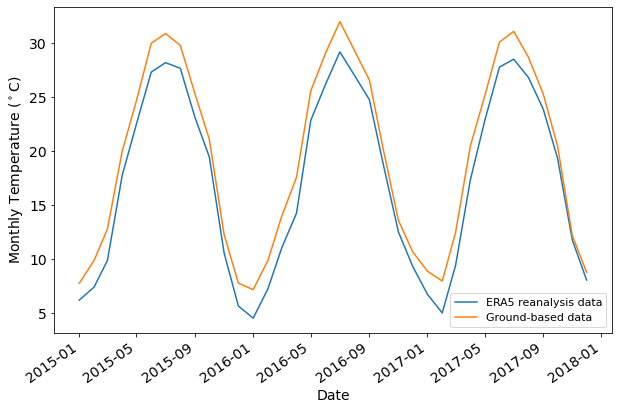

R2 =  0.9246559258669137
MBE =  2.1729961819118926


In [10]:
# era5 of shiraz station
alpha = 1  # scaling factor
res = 0.25 # resolution of gridded data 

bbox_shz = [29.3882, 30.0822, 51.8692, 53.2095]
era_temp = get_era5(DS, bbox_shz, alpha, res)


# synoptic data of Shiraz
file = './data/Shiraz.xlsx'
syn_temp = get_ground(file)

plot_era5_syn(era_temp, syn_temp, 'Shiraz')
R2 = r2(era_temp, syn_temp)
print('R2 = ', r2(era_temp, syn_temp))
print('MBE = ', mbe(era_temp, syn_temp))

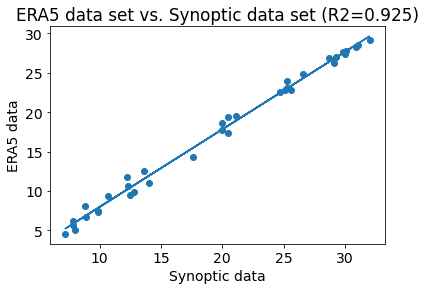

In [11]:
# Plot r^2
from sklearn.linear_model import LinearRegression

station = 'shiraz'

fig, ax = plt.subplots()
era = era_temp['2015':'2017'][:]
syn = syn_temp['2015':'2017'][:]
ax.scatter(syn, era)
#ax.plot([syn.min(), syn.max()], [syn.min(), syn.max()], 'k--', lw=4)
ax.set_xlabel('Synoptic data')
ax.set_ylabel('ERA5 data')
#regression line
y_test, y_predicted = syn.to_numpy().reshape(-1,1), era.to_numpy().reshape(-1,1)
ax.plot(y_test, LinearRegression().fit(y_test, y_predicted).predict(y_test))

#ax.annotate("r-squared = {:.3f}".format(r2_score(y_test, y_predicted)), xy=(2, 2))

ax.set_title("ERA5 data set vs. Synoptic data set (R2={:.3f})".format(R2))

plt.savefig(r'./images/R2_'+station+'.jpg', dpi=300)
plt.show()

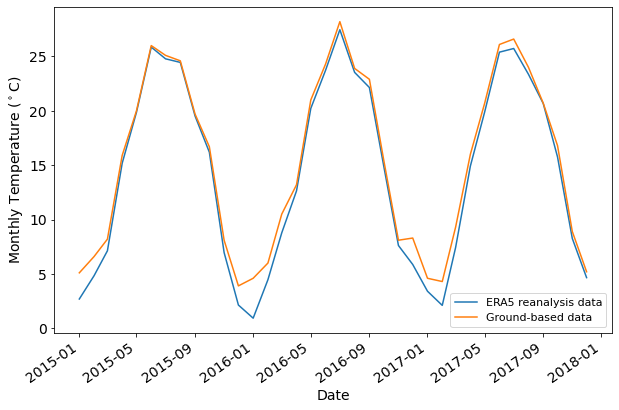

R2 =  0.977714195555065
MBE =  1.0016791449652778


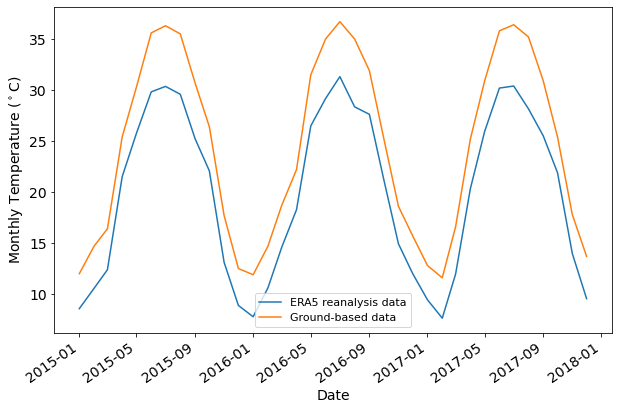

R2 =  0.6572314431076803
MBE =  4.659673902723524


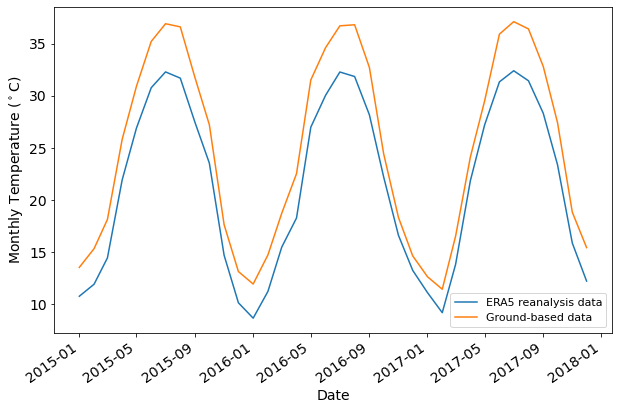

R2 =  0.7953038456789411
MBE =  3.5684149848090274


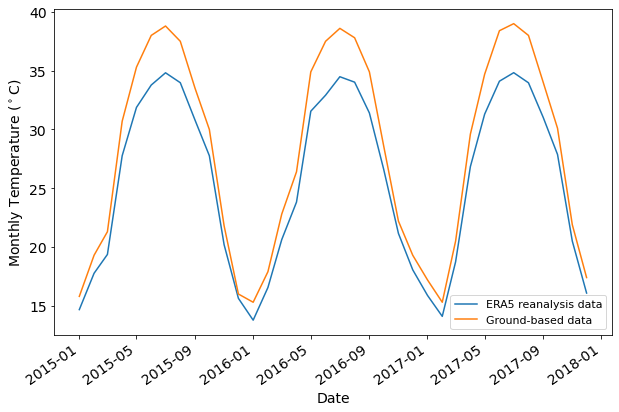

R2 =  0.85416231327918
MBE =  2.546759202745226


In [12]:
#Calling function for other stations
stations = {'Abadeh':[31.1308, 31.2169, 52.5988, 52.7069],
           'Darab':[28.7272, 28.7756, 54.5118, 54.5866],
           'Kazerun':[29.5918, 29.6411, 51.6290, 51.6895],
           'Lamerd':[27.2945, 27.3832, 53.1088, 53.2763]}

for st in stations.keys():
    print('Station: ', st)
    era_temp = get_era5(DS, stations.get(st))

    # synoptic data
    file = './data/'+st+'.xlsx'
    syn_temp = get_ground(file)

    plot_era5_syn(era_temp, syn_temp, st)
    R2 = r2(era_temp, syn_temp)
    print('R2 = ', r2(era_temp, syn_temp))
    print('MBE = ', mbe(era_temp, syn_temp))
    